# Advanced Machine Learning - Exercise 3
Dominique Cheray & Manuel Krämer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.optim
import torch.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d

## 1) Introduction

In [2]:
mb_size = 100 # mini-batch size of 100


trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),
                                                 (0.5, 0.5, 0.5))])


dataset = dset.MNIST("./", download = True,
                     train = True,
                     transform = trans)

test_dataset = dset.MNIST("./", download=True,
                          train=False,
                          transform = trans)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=mb_size,
                                         shuffle=True, num_workers=1,
                                         pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=mb_size,
                                          shuffle=True, num_workers=1,
                                          pin_memory=True)


def init_weights(shape):
    # xavier initialization (a good initialization is important!)
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    fan_in = shape[0]
    fan_out = shape[1]
    variance = 2.0/(fan_in + fan_out)
    w = torch.randn(size=shape)*np.sqrt(variance)
    w.requires_grad = True
    return w


def rectify(X):
    return torch.max(torch.zeros_like(X), X)


# you can also use torch.nn.functional.softmax on future sheets
def softmax(X):
    c = torch.max(X, dim=1)[0].reshape(mb_size, 1)
    # this avoids a blow up of the exponentials
    # but calculates the same formula
    stabelized = X-c
    exp = torch.exp(stabelized)
    return exp/torch.sum(exp, dim=1).reshape(mb_size, 1)


# this is an example as a reduced version of the pytorch internal RMSprop optimizer
class RMSprop(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(1 - alpha, grad, grad)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(-group['lr'], grad, avg)

In [7]:
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    #X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    #h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    #h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax


w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])


# put this into a training loop over 100 epochs
for i in range(101):
    print("Epoch: {}".format(i+1))
    avg_train_loss = 0
    for (j, (X, y)) in enumerate(dataloader, 0):
        noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
        optimizer.zero_grad()
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_train_loss = avg_train_loss + cost
        cost.backward()
        optimizer.step()
    if i % 10 == 0:
        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))
        
    avg_test_loss = 0
    for (k, (X, y)) in enumerate(test_loader, 0):
        noise_py_x = model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 1.0, 1.0)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_test_loss = avg_test_loss + cost
    if i % 10 == 0:
        print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))

Epoch: 1
Average Train Loss: 0.39014214277267456
Average Test Loss: 0.23901870846748352
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 0.1483016163110733
Average Test Loss: 0.5034511089324951
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 0.10333895683288574
Average Test Loss: 0.3108282685279846
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 0.06280354410409927
Average Test Loss: 0.5835622549057007
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 0.05613270401954651
Average Test Loss: 0.7988427877426147
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Average Train Loss: 0.038002606481313705
Average Test Loss: 0.6501759886741638
Epoch: 52
Epoch: 53
Epoch: 54


## 2) Dropout

In [4]:
def dropout(X, p_drop=1.):
    if p_drop > 0 and p_drop < 1:
        phi = np.random.binomial(1, p_drop, X.shape)
        phi[phi == 1] = 1.0 / p_drop
        phi = torch.from_numpy(phi).float()
        X = X * phi
    return X

In [4]:
def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = rectify(X @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax


w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))

optimizer = RMSprop([w_h, w_h2, w_o])


# put this into a training loop over 100 epochs
for i in range(101):
    print("Epoch: {}".format(i+1))
    avg_train_loss = 0
    for (j, (X, y)) in enumerate(dataloader, 0):
        noise_py_x = dropout_model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 0.8, 0.7)
        optimizer.zero_grad()
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_train_loss = avg_train_loss + cost
        cost.backward()
        optimizer.step()
    if i % 10 == 0:
        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))
        
    avg_test_loss = 0
    for (k, (X, y)) in enumerate(test_loader, 0):
        noise_py_x = dropout_model(X.reshape(mb_size, 784), w_h, w_h2, w_o, 1.0, 1.0)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_test_loss = avg_test_loss + cost
    if i % 10 == 0:
        print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))

Epoch: 1
Average Train Loss: 0.47026142477989197
Average Test Loss: 0.3844311237335205
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 0.3270871341228485
Average Test Loss: 0.2947015166282654
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 0.37221449613571167
Average Test Loss: 0.47056320309638977
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 0.422280877828598
Average Test Loss: 0.40751662850379944
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 0.4475133717060089
Average Test Loss: 0.5863760113716125
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Average Train Loss: 0.483291357755661
Average Test Loss: 0.6781806349754333
Epoch: 52
Epoch: 53
Epoch: 54
Epoch

##### Question:
Dropout means that at training stage individual neurons are either dropped out of the net with probability 1-p or kept with probability p. So only a reduced network is left.
A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to over-fitting of training data.
Dropout is an approach to regularization in neural networks which helps reducing interdependent learning amongst the neurons.

The model without dropout overfits badly. The train error goes down to zero, the test error goes up to one. The model with dropout overfits less. The train error goes to one half, but the test error is still quite high. But not as high as the other model.

## 3) Parametric Relu

In [6]:
def PRelu(X, a):
    # clone the input otherwise later on you get an error from pytorch for
    # inplace operation on a variable needed for gradient computation
    X_copy = X.clone()
    tmp = torch.mul(X, a)
    X_copy[X <= 0] = tmp[X <= 0]
    return X_copy


def init_alpha(shape):
    a = torch.zeros(size=shape)
    a.requires_grad = True
    return a

In [7]:
def prelu_model(X, w_h, w_h2, w_o, a, a2, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    h = PRelu(X @w_h, a)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2, a2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax


w_h = init_weights((784, 625))
w_h2 = init_weights((625, 625))
w_o = init_weights((625, 10))
a = init_alpha((mb_size, 625))
a2 = init_alpha((mb_size, 625))

optimizer = RMSprop([w_h, w_h2, w_o, a, a2])


# put this into a training loop over 100 epochs
for i in range(101):
    print("Epoch: {}".format(i+1))
    avg_train_loss = 0
    for (j, (X, y)) in enumerate(dataloader, 0):
        noise_py_x = prelu_model(X.reshape(mb_size, 784), w_h, w_h2, w_o, a, a2, 0.8, 0.7)
        optimizer.zero_grad()
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_train_loss = avg_train_loss + cost
        cost.backward()
        optimizer.step()
    if i % 10 == 0:
        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))
        
    avg_test_loss = 0
    for (k, (X, y)) in enumerate(test_loader, 0):
        noise_py_x = prelu_model(X.reshape(mb_size, 784), w_h, w_h2, w_o, a, a2, 1.0, 1.0)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_test_loss = avg_test_loss + cost
    if i % 10 == 0:
        print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))

Epoch: 1
Average Train Loss: 0.478598952293396
Average Test Loss: 0.36846619844436646
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Average Train Loss: 0.19397574663162231
Average Test Loss: 0.27876579761505127
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Average Train Loss: 0.16181008517742157
Average Test Loss: 0.24760571122169495
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Average Train Loss: 0.1409028172492981
Average Test Loss: 0.21978114545345306
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Average Train Loss: 0.13759374618530273
Average Test Loss: 0.25001516938209534
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Average Train Loss: 0.1348763257265091
Average Test Loss: 0.23010067641735077
Epoch: 52
Epoch: 53
Epoch: 54

## 4) Convolutional layers
### 4.1) Create a Convolutional network

In [5]:
def conv_model(X, conv_w1, conv_w2, conv_w3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    conv1 = rectify(conv2d(X, conv_w1))
    pool1 = max_pool2d(conv1, (2, 2))
    drop1 = dropout(pool1, p_drop_hidden)
    conv2 = rectify(conv2d(drop1, conv_w2))
    pool2 = max_pool2d(conv2, (2, 2))
    drop2 = dropout(pool2, p_drop_hidden)
    conv3 = rectify(conv2d(drop2, conv_w3))
    pool3 = max_pool2d(conv3, (2, 2))
    drop3 = dropout(pool3, p_drop_hidden)
    h2 = rectify(torch.reshape(drop3, (mb_size, 128)) @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


conv_w1 = init_weights((32, 1, 5, 5))
conv_w2 = init_weights((64, 32, 5, 5))
conv_w3 = init_weights((128, 64, 2, 2))
w_h2 = init_weights((128, 625))
w_o = init_weights((625, 10))

conv_optimizer = RMSprop([conv_w1, conv_w2, conv_w3, w_h2, w_o])

### 4.2) Application of Convolutional network

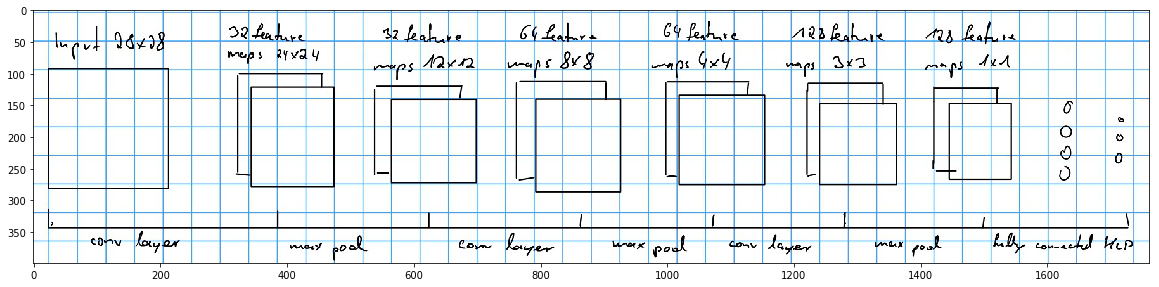

In [10]:
import matplotlib.image as mpimg
fig = plt.figure(figsize=(20, 15))
img=mpimg.imread('CNN.jpg')
imgplot = plt.imshow(img)
plt.show()

In [6]:
# can't train it for more than one epoch, otherwise I run out of memory
for i in range(1):
    print("Epoch: {}".format(i+1))
    avg_train_loss = 0
    for (j, (X, y)) in enumerate(dataloader, 0):
        noise_py_x = conv_model(X.view(-1, 1, 28, 28), conv_w1, conv_w2, conv_w3, w_h2, w_o, 0.8, 0.7)
        conv_optimizer.zero_grad()
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_train_loss = avg_train_loss + cost
        cost.backward()
        conv_optimizer.step()
    if i % 10 == 0:
        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))
        
    avg_test_loss = 0
    for (k, (X, y)) in enumerate(test_loader, 0):
        noise_py_x = conv_model(X.view(-1, 1, 28, 28), conv_w1, conv_w2, conv_w3, w_h2, w_o, 1.0, 1.0)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_test_loss = avg_test_loss + cost
    if i % 10 == 0:
        print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))

Epoch: 1
Average Train Loss: 0.8709688186645508
Average Test Loss: 0.288282573223114


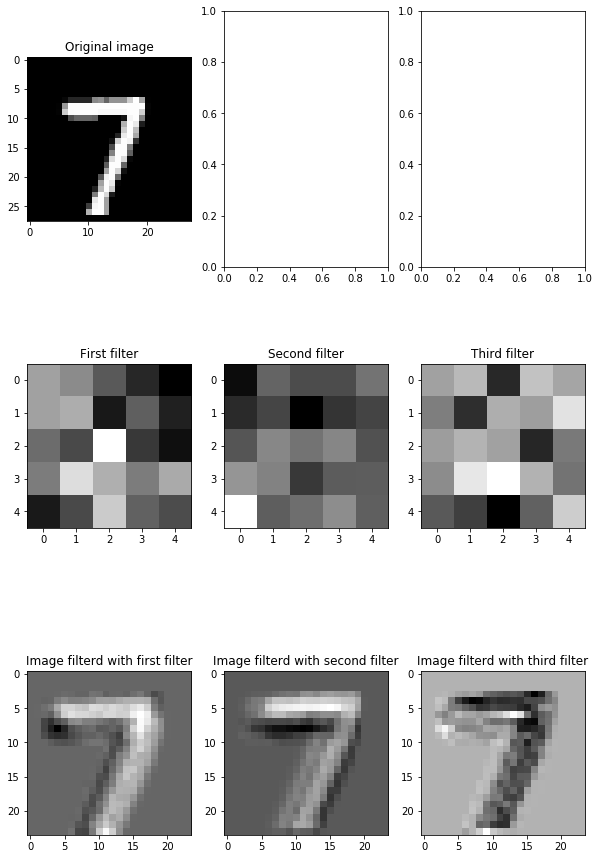

In [14]:
# get next batch of images from testloader
(data, label) = next(iter(test_loader))

# take first image of batch and transform it to numpy
# for later visualization
img_numpy = data[0, 0, :, :].numpy()
# take three filters from first convolutional layer and transform
# them to numpy for later visualiztaion
filter1_numpy = conv_w1[1, 0, :, :].detach().numpy()
filter2_numpy = conv_w1[2, 0, :, :].detach().numpy()
filter3_numpy = conv_w1[3, 0, :, :].detach().numpy()

# do convolution on batch with first layer
conv1 = conv2d(data, conv_w1)
# now take first image convoluted with the filters chosen earlier and
# transform them to numpy for visualiztaion
im_filter1 = conv1[0, 1, :, :].detach().numpy()
im_filter2 = conv1[0, 2, :, :].detach().numpy()
im_filter3 = conv1[0, 3, :, :].detach().numpy()

# do the visulization
fig, axes = plt.subplots(3, 3, figsize=(10, 16))
axes[0, 0].imshow(img_numpy, plt.cm.gray)
axes[0, 0].set_title("Original image")
axes[1, 0].imshow(filter1_numpy, plt.cm.gray)
axes[1, 0].set_title("First filter")
axes[1, 1].imshow(filter2_numpy, plt.cm.gray)
axes[1, 1].set_title("Second filter")
axes[1, 2].imshow(filter3_numpy, plt.cm.gray)
axes[1, 2].set_title("Third filter")
axes[2, 0].imshow(im_filter1, plt.cm.gray)
axes[2, 0].set_title("Image filterd with first filter")
axes[2, 1].imshow(im_filter2, plt.cm.gray)
axes[2, 1].set_title("Image filterd with second filter")
axes[2, 2].imshow(im_filter3, plt.cm.gray)
axes[2, 2].set_title("Image filterd with third filter")
plt.show()

#### Use unisotropic filters

In [5]:
def weird_conv_model(X, conv_w1, conv_w2, conv_w3, w_h2, w_o, p_drop_input, p_drop_hidden):
    X = dropout(X, p_drop_input)
    conv1 = rectify(conv2d(X, conv_w1))
    pool1 = max_pool2d(conv1, (2, 2))
    drop1 = dropout(pool1, p_drop_hidden)
    conv2 = rectify(conv2d(drop1, conv_w2))
    pool2 = max_pool2d(conv2, (2, 2))
    drop2 = dropout(pool2, p_drop_hidden)
    conv3 = rectify(conv2d(drop2, conv_w3))
    pool3 = max_pool2d(conv3, (2, 2))
    drop3 = dropout(pool3, p_drop_hidden)
    h2 = rectify(torch.reshape(drop3, (mb_size, 128)) @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

conv_w1_uniso = init_weights((32, 1, 5, 6))
conv_w2_uniso = init_weights((64, 32, 4, 5))
conv_w3_uniso = init_weights((128, 64, 2, 2))
w_h2_uniso = init_weights((128, 625))
w_o_uniso = init_weights((625, 10))

conv_optimizer_uniso = RMSprop([conv_w1_uniso, conv_w2_uniso, conv_w3_uniso, w_h2_uniso, w_o_uniso])

# put this into a training loop over 100 epochs
# only one epoch because memory, you know
for i in range(1):
    print("Epoch: {}".format(i+1))
    avg_train_loss = 0
    for (j, (X, y)) in enumerate(dataloader, 0):
        noise_py_x = weird_conv_model(X.view(-1, 1, 28, 28), conv_w1_uniso, conv_w2_uniso, conv_w3_uniso, w_h2_uniso, w_o_uniso, 0.8, 0.7)
        conv_optimizer_uniso.zero_grad()
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_train_loss = avg_train_loss + cost
        cost.backward()
        conv_optimizer_uniso.step()
    if i % 10 == 0:
        print("Average Train Loss: {}".format(avg_train_loss / (j + 1)))
        
    avg_test_loss = 0
    for (k, (X, y)) in enumerate(test_loader, 0):
        noise_py_x = weird_conv_model(X.view(-1, 1, 28, 28), conv_w1_uniso, conv_w2_uniso, conv_w3_uniso, w_h2_uniso, w_o_uniso, 1.0, 1.0)
        cost = torch.nn.functional.cross_entropy(noise_py_x, y)
        avg_test_loss = avg_test_loss + cost
    if i % 10 == 0:
        print("Average Test Loss: {}".format(avg_test_loss / (k + 1)))

Epoch: 1
Average Train Loss: 0.8378913402557373
Average Test Loss: 0.33675140142440796


The test loss of the convolutional network with the unisotropic filters is worse but only slightly worse than the convoltional network with the isotropic filters. Since the unisotropic filters are not that weird in size it makes sense that the network is only slightly worse.